<a href="https://colab.research.google.com/github/eunzzae/Off_Study_ML/blob/main/231006_%EC%8B%A4%EC%8A%B5(1)_%5BML_Project%5D_2023_%EC%A0%84%EB%A0%A5%EC%82%AC%EC%9A%A9%EB%9F%89_%EC%98%88%EC%B8%A1_AI_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning 프로젝트 수행을 위한 코드 구조화

- ML project를 위해서 사용하는 템플릿 코드를 만듭니다.

1. **필요한 라이브러리와 데이터를 불러옵니다.**


2. **EDA를 수행합니다.** 이 때 EDA의 목적은 풀어야하는 문제를 위해서 수행됩니다.


3. **전처리를 수행합니다.** 이 때 중요한건 **feature engineering**을 어떻게 하느냐 입니다.


4. **데이터 분할을 합니다.** 이 때 train data와 test data 간의 분포 차이가 없는지 확인합니다.


5. **학습을 진행합니다.** 어떤 모델을 사용하여 학습할지 정합니다. 성능이 잘 나오는 GBM을 추천합니다.


6. **hyper-parameter tuning을 수행합니다.** 원하는 목표 성능이 나올 때 까지 진행합니다. 검증 단계를 통해 지속적으로 **overfitting이 되지 않게 주의**하세요.


7. **최종 테스트를 진행합니다.** 데이터 분석 대회 포맷에 맞는 submission 파일을 만들어서 성능을 확인해보세요.

## 1. 라이브러리, 데이터 불러오기

In [44]:
# 설치에 필요한 라이브러리들이 있다면 모두 적어둡니다. anaconda에 기본적으로 설치되지 않은 라이브러리들을 적어두세요.
!pip install lightgbm optuna

In [45]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

In [46]:
# flag setting
feature_reducing = False #'pca' # or 'fi'

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
# 데이터를 불러옵니다.
base_path = '/content/drive/MyDrive/Colab Notebooks/data/2023_electric/'
train = pd.read_csv(base_path + 'train.csv')
building_info = pd.read_csv(base_path + 'building_info.csv')
test = pd.read_csv(base_path + 'test.csv')
print(train.shape, building_info.shape, test.shape)

(204000, 10) (100, 7) (16800, 7)


## 2. EDA

- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.


- class imbalance, target distribution, outlier, correlation을 확인합니다.

In [49]:
## On your Own
display(train.info())
display(test.info())
display(building_info.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_date_time  16800 non-null  object 
 1   건물번호           16800 non-null  int64  
 2   일시             16800 non-null  object 
 3   기온(C)          16800 non-null  float64
 4   강수량(mm)        16800 non-null  float64
 5   풍속(m/s)        16800 non-null  float64
 6   습도(%)          16800 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 918.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    object 
 5   ESS저장용량(kWh)  100 non-null    object 
 6   PCS용량(kW)     100 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ KB


None

In [50]:
# sns.heatmap(train.corr(), annot=True, fmt='.2f')
# sns.heatmap(test.corr(), annot=True, fmt='.3f')

In [51]:
train.columns

Index(['num_date_time', '건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'],
      dtype='object')

In [52]:
train = train.drop(columns = ['일조(hr)', '일사(MJ/m2)'])
train.columns = ['num_date_time', 'num', 'date_time', 'temperature', 'precipitation',
                 'windspeed', 'humidity', 'target']
test.columns = ['num_date_time', 'num', 'date_time', 'temperature', 'precipitation',
                 'windspeed', 'humidity']

In [53]:
train.info()
test.info()
building_info.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   num            204000 non-null  int64  
 2   date_time      204000 non-null  object 
 3   temperature    204000 non-null  float64
 4   precipitation  43931 non-null   float64
 5   windspeed      203981 non-null  float64
 6   humidity       203991 non-null  float64
 7   target         204000 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 12.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_date_time  16800 non-null  object 
 1   num            16800 non-null  int64  
 2   date_time      16800 non-null  object 
 3   temperature    16800 non-null  float64
 4   

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000


In [54]:
cond1 = (building_info['태양광용량(kW)']=='-')
cond2 = (building_info['ESS저장용량(kWh)']=='-')
cond3 = (building_info['PCS용량(kW)']=='-')
building_info[cond1|cond2|cond3]

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000
...,...,...,...,...,...,...,...
95,96,호텔및리조트,93314.00,60500.00,-,-,-
96,97,호텔및리조트,55144.67,25880.00,-,-,-
97,98,호텔및리조트,53578.62,17373.75,-,-,-
98,99,호텔및리조트,53499.00,40636.00,-,-,-


In [55]:
building_info.loc[building_info['태양광용량(kW)']=='-', '태양광용량(kW)'] = 0
building_info.loc[building_info['ESS저장용량(kWh)']=='-', 'ESS저장용량(kWh)'] = 0
building_info.loc[building_info['PCS용량(kW)']=='-', 'PCS용량(kW)'] = 0

building_info['태양광용량(kW)'] = building_info['태양광용량(kW)'].astype('float')
building_info['ESS저장용량(kWh)'] = building_info['ESS저장용량(kWh)'].astype('float')
building_info['PCS용량(kW)'] = building_info['PCS용량(kW)'].astype('float')

In [56]:
building_info.columns = ['num', 'type', 'area1', 'area2', 'solar', 'ESS', 'PCS']
building_info

,num,type,area1,area2,solar,ESS,PCS
0,1,건물기타,110634.00,39570.00,0.0,0.0,0.0
1,2,건물기타,122233.47,99000.00,0.0,0.0,0.0
2,3,건물기타,171243.00,113950.00,40.0,0.0,0.0
3,4,건물기타,74312.98,34419.62,60.0,0.0,0.0
4,5,건물기타,205884.00,150000.00,0.0,2557.0,1000.0
...,...,...,...,...,...,...,...
95,96,호텔및리조트,93314.00,60500.00,0.0,0.0,0.0
96,97,호텔및리조트,55144.67,25880.00,0.0,0.0,0.0
97,98,호텔및리조트,53578.62,17373.75,0.0,0.0,0.0
98,99,호텔및리조트,53499.00,40636.00,0.0,0.0,0.0


In [57]:
building_info.type.value_counts()

건물기타       15
공공          8
대학교         8
백화점및아울렛     8
병원          8
상용          8
아파트         8
연구소         8
지식산업센터      8
할인마트        8
호텔및리조트      8
데이터센터       5
Name: type, dtype: int64

In [59]:
train = pd.merge(train, building_info, on='num') # inner join

In [61]:
pd.pivot_table(data = train, index = 'type', values = 'target') # 건물유형을 categorical feature로 사용

,target
type,
건물기타,1971.725375
공공,1683.978456
대학교,5458.636005
데이터센터,5396.897682
백화점및아울렛,2263.871801
병원,2912.790081
상용,2299.375129
아파트,1309.000627
연구소,2808.760916


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47932 (\N{HANGUL SYLLABLE MUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

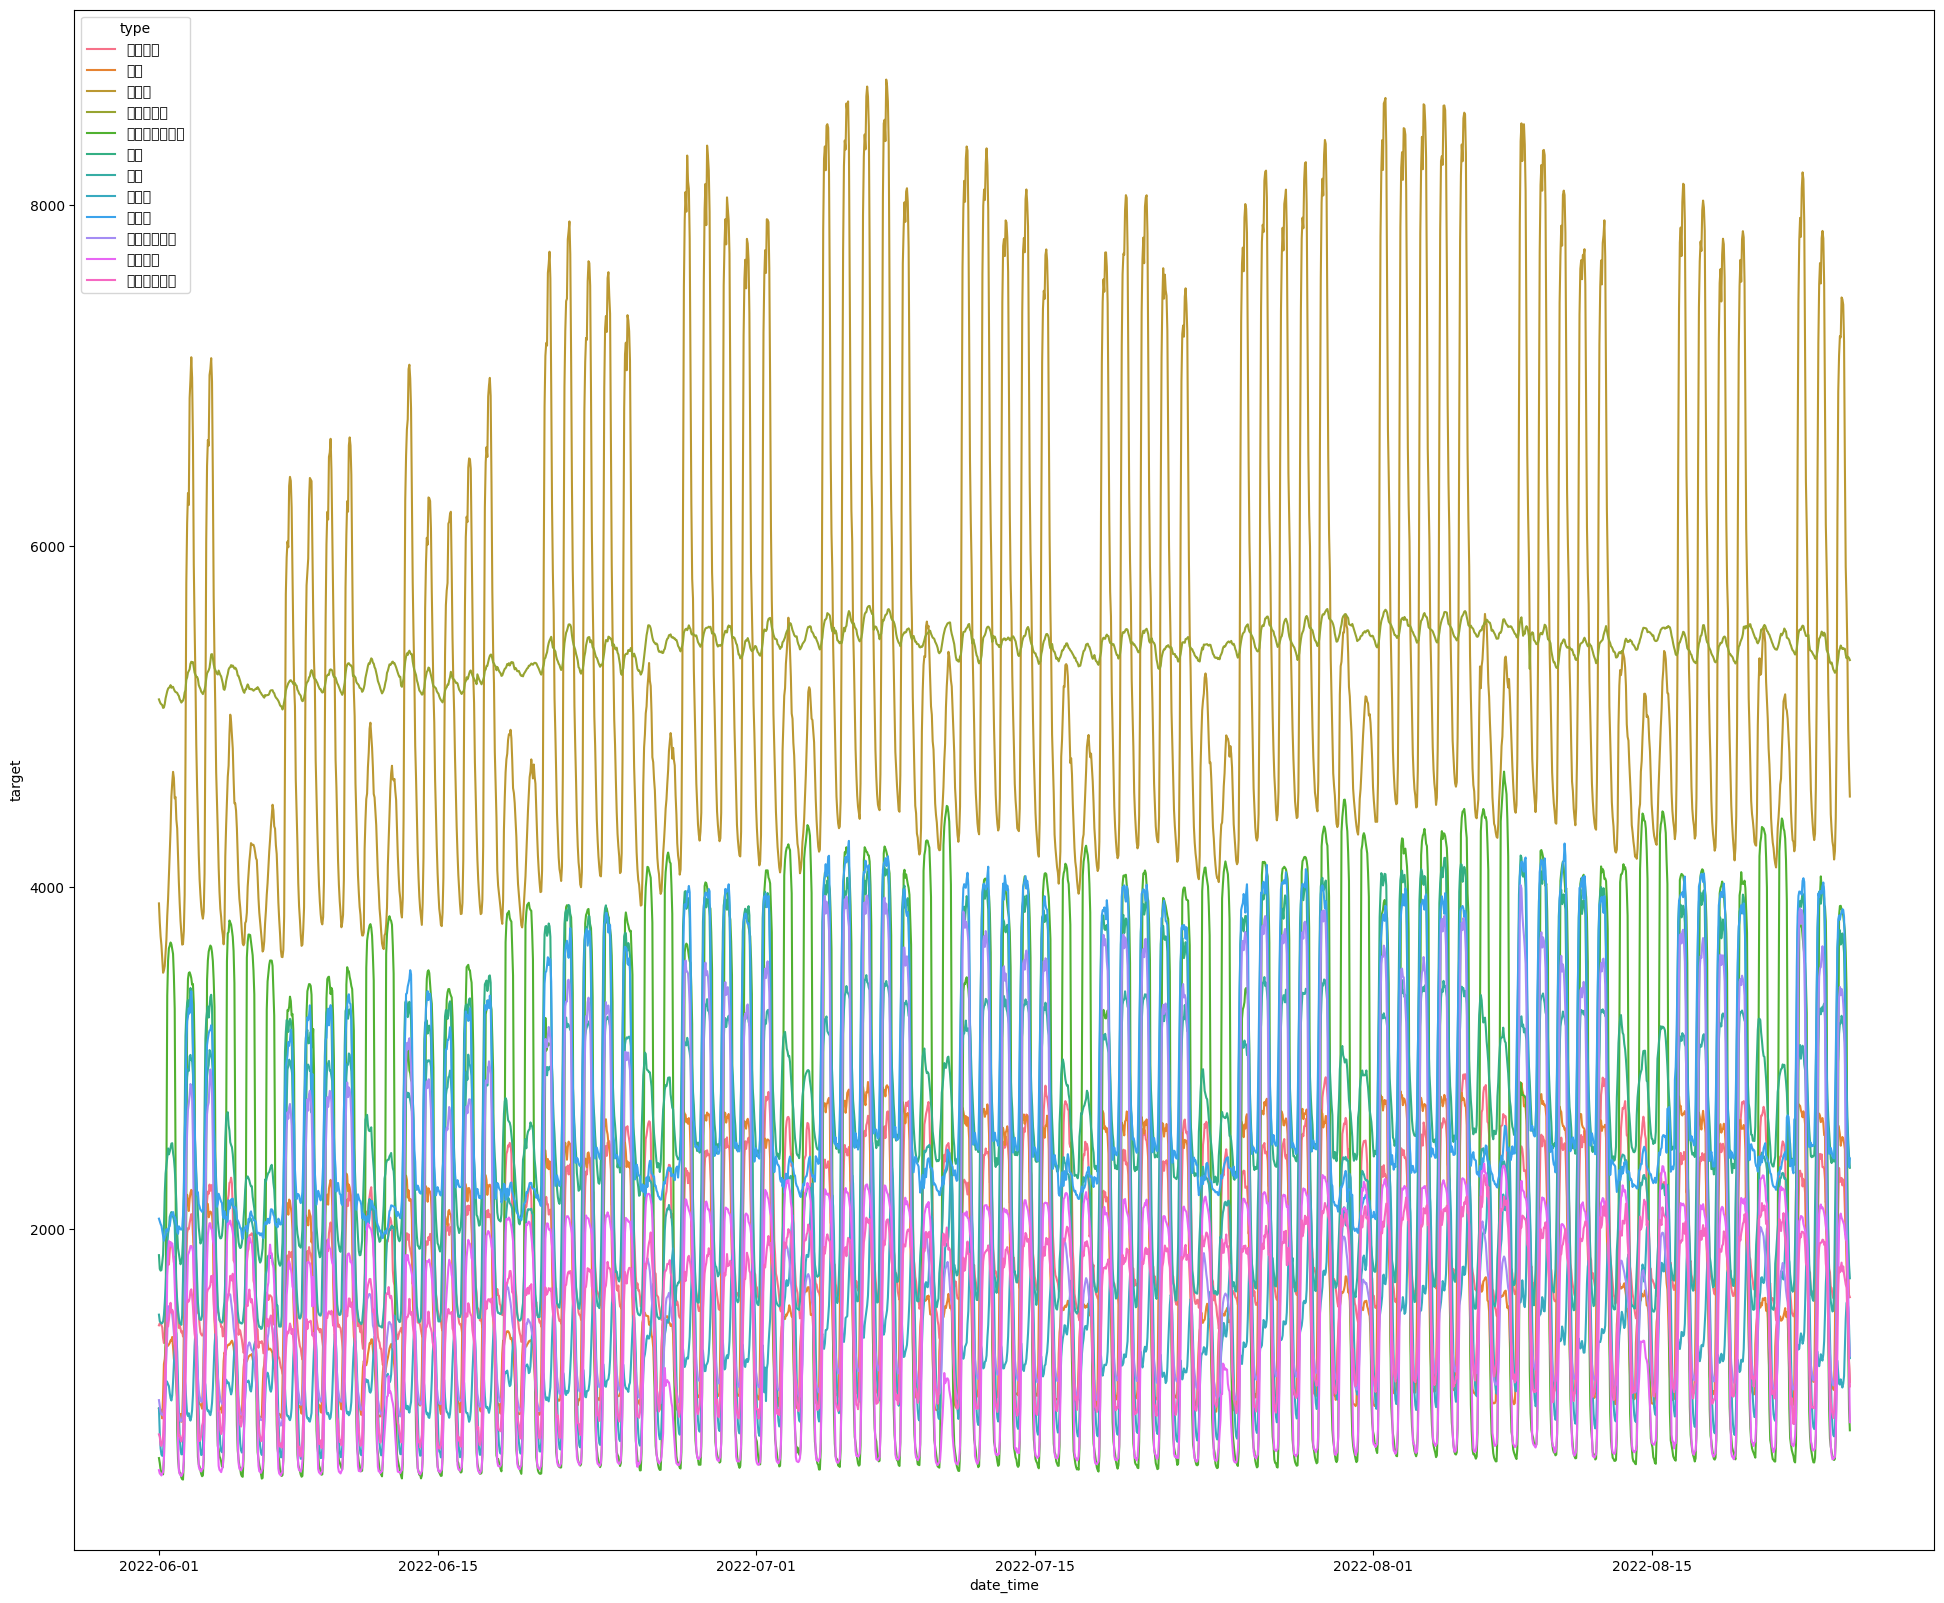

In [62]:
# train.date_time = pd.to_datetime(train.date_time)

# plt.figure(figsize=(24,20))
# sns.lineplot(data=train,x='date_time', y='target', hue='type', errorbar=None)
# plt.show()

# 건물 타입별로 전력사용량 패턴이 다르다!
# 타임시리즈케이민즈? 비슷한 패턴의 그룹끼리 묶어줌

이런 식으로 여러가지 그래프를 그려가며, 데이터에 대한 인사이트를 얻습니다!

### 3. 전처리

#### 결측치 처리

In [64]:
# 결측치가 있는 column
train.info() # 강수량 결측치 고민!
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204000 entries, 0 to 203999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   num_date_time  204000 non-null  object        
 1   num            204000 non-null  int64         
 2   date_time      204000 non-null  datetime64[ns]
 3   temperature    204000 non-null  float64       
 4   precipitation  43931 non-null   float64       
 5   windspeed      203981 non-null  float64       
 6   humidity       203991 non-null  float64       
 7   target         204000 non-null  float64       
 8   type           204000 non-null  object        
 9   area1          204000 non-null  float64       
 10  area2          204000 non-null  float64       
 11  solar          204000 non-null  float64       
 12  ESS            204000 non-null  float64       
 13  PCS            204000 non-null  float64       
dtypes: datetime64[ns](1), float64(10), int64(1), object(

In [65]:
train.precipitation = train.precipitation.fillna(0) # 강수량은 0으로 채우자
train.windspeed = train.windspeed.interpolate()
train.humidity = train.humidity.interpolate()

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204000 entries, 0 to 203999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   num_date_time  204000 non-null  object        
 1   num            204000 non-null  int64         
 2   date_time      204000 non-null  datetime64[ns]
 3   temperature    204000 non-null  float64       
 4   precipitation  204000 non-null  float64       
 5   windspeed      204000 non-null  float64       
 6   humidity       204000 non-null  float64       
 7   target         204000 non-null  float64       
 8   type           204000 non-null  object        
 9   area1          204000 non-null  float64       
 10  area2          204000 non-null  float64       
 11  solar          204000 non-null  float64       
 12  ESS            204000 non-null  float64       
 13  PCS            204000 non-null  float64       
dtypes: datetime64[ns](1), float64(10), int64(1), object(

In [ ]:
# time feature도 생성해야함

In [67]:
# 각 feature들이 discretes한지 continuous한지 확인합니다. -> categorical feature encoding
train = pd.get_dummies(data = train, columns = ['type'])
train

,num_date_time,num,date_time,temperature,precipitation,windspeed,humidity,target,area1,area2,...,type_대학교,type_데이터센터,type_백화점및아울렛,type_병원,type_상용,type_아파트,type_연구소,type_지식산업센터,type_할인마트,type_호텔및리조트
0,1_20220601 00,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,1085.28,110634.00,39570.00,...,0,0,0,0,0,0,0,0,0,0
1,1_20220601 01,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,1047.36,110634.00,39570.00,...,0,0,0,0,0,0,0,0,0,0
2,1_20220601 02,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,974.88,110634.00,39570.00,...,0,0,0,0,0,0,0,0,0,0
3,1_20220601 03,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,953.76,110634.00,39570.00,...,0,0,0,0,0,0,0,0,0,0
4,1_20220601 04,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,986.40,110634.00,39570.00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,2022-08-24 19:00:00,23.1,0.0,0.9,86.0,881.04,57497.84,40035.23,...,0,0,0,0,0,0,0,0,0,1
203996,100_20220824 20,100,2022-08-24 20:00:00,22.4,0.0,1.3,86.0,798.96,57497.84,40035.23,...,0,0,0,0,0,0,0,0,0,1
203997,100_20220824 21,100,2022-08-24 21:00:00,21.3,0.0,1.0,92.0,825.12,57497.84,40035.23,...,0,0,0,0,0,0,0,0,0,1
203998,100_20220824 22,100,2022-08-24 22:00:00,21.0,0.0,0.3,94.0,640.08,57497.84,40035.23,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# 중복정보가 있는 column 제거하기 위해 상관계수를 확인해봅니다.
correlated_features =

#### 다중공선성 처리

In [ ]:
# VIF(Variance Inflation Factor)를 이용하여 다중공선성(서로 상관이 높은) column들을 제거합니다.
# VIF가 1이라면, 다른 feature와 전혀 상관관계가 없고 그 때의 R^2는 0입니다.


In [ ]:
# VIF가 threshold를 넘기는 feature들을 제거합니다.
threshold =


#### feature extraction

- 차원의 저주를 해결하거나, 데이터의 feature 조합을 이용하는 새로운 feature를 생성할 때, PCA를 사용합니다.

- 분석에 사용할 feature를 선택하는 과정도 포함합니다.

### 4. 학습 데이터 분할

In [68]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
from sklearn.model_selection import train_test_split
# time feature 만들면 date_time 필요함

X = train.drop(columns = ['num_date_time', 'date_time', 'target'])
y = train.target

# for OOF-prediction split 5% of data as validation dataset. 시간을 가지고 뒤에 데이터를 잘라서 (week) 사용해도 됨
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42)

In [69]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(193800, 22) (193800,) (10200, 22) (10200,)


In [ ]:
# PCA 적용 -> 차원을 줄여주는 역할을 해줌
# 0.90은 원본 데이터의 분산(정보를)을 90% 까지 표현할 수 있는 축을 사용하겠다.라는 뜻
# 나중에 사용해보기

if feature_reducing:
  from sklearn.decomposition import PCA

  pca = PCA(n_components=0.90,  # -> 원본 데이터의 정보를 90% 표현하는 공간의 차원
            whiten=True,        # standardization
            random_state=42)

  pda_df = pd.DataFrame(data=pca.fit_transform(X_train), columns=[f'PC{i}' for i in range(1, X_train.shape[1])])
  display(pca_df)

  # pca.transform(X_val)

### 5. 학습 및 평가

In [73]:
# 간단하게 LightGBM 테스트
# 적당한 hyper-parameter 조합을 두었습니다. (항상 best는 아닙니다. 예시입니다.)

# param_grid = {
#     "max_bin" : 20,
#     "learning_rate" : 0.0025,
#     "objective" : "regression",
#     "boosting_type" : "gbdt",
#     "metric" : "mae",
#     "sub_feature" : 0.345,
#     "bagging_fraction" : 0.85,
#     "bagging_freq" : 40,
#     "num_leaves" : 512,
#     "min_data" : 500,
#     "min_hessian" : 0.05,
#     "verbose" : 2,
#     "feature_fraction_seed" : 2,
#     "bagging_seed" : 3
# }

model = LGBMRegressor()

In [74]:
print("\nFitting LightGBM...")
model.fit(X_train, y_train)


Fitting LightGBM...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 193800, number of used features: 22
[LightGBM] [Info] Start training from score 2451.946577


LGBMRegressor()

In [75]:
# metric은 그때마다 맞게 바꿔줘야 합니다.
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred)*2)/(np.abs(true) + np.abs(pred))) * 100

evaluation_metric = SMAPE

In [76]:
print("Prediction")
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)


train_score = evaluation_metric(y_train, pred_train)
val_score = evaluation_metric(y_val, pred_val)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % val_score)

Prediction
Train Score : 24.8146
Test Score : 25.8022


### 6. Hyper-parameter Tuning

> GridSearchCV

** LightGBM의 hyperparameter **

[Official Documentation] https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

[Blog 1] https://smecsm.tistory.com/133

[Blog 2] https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

[Blog 3] https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/

In [ ]:
# GridSearchCV를 이용하여 가장 좋은 성능을 가지는 모델을 찾아봅시다. (이것은 첫번째엔 선택입니다.)
# Lightgbm은 hyper-parameter의 영향을 많이 받기 때문에, 저는 보통 맨처음에 한번 정도는 가볍게 GCV를 해봅니다.
# 성능 향상이 별로 없다면, lightgbm으로 돌린 대략적인 성능이 이 정도라고 생각하면 됩니다.
# 만약 성능 향상이 크다면, 지금 데이터는 hyper-parameter tuning을 빡빡하게 하면 성능 향상이 많이 이끌어 낼 수 있습니다.

from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth" : [8, 16, None],
    "n_estimators" : [100, 300, 500],
    "max_bin" : [20],
    "learning_rate" : [0.001, 0.0025, 0.003],
    "objective" : ["regression"],
    "boosting_type" : ["gbdt"],
    "metric" : ["mae"],
    "sub_feature" : [0.345],
    "bagging_fraction" : [0.7, 0.75, 0.85],
    "bagging_freq" : [40],
    "num_leaves" : [256, 512],
    "min_data" : [500],
    "verbose" : [-1], # 필수
    "min_hessian" : [0.05],
    "feature_fraction_seed" : [2],
    "bagging_seed" : [3]
}


gcv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5,
                  n_jobs=-1, verbose=1)

gcv.fit(X_train, y_train)
print("Best Estimator : ", gcv.best_estimator_)

In [ ]:
print("Prediction with Best Estimator")
gcv_pred_train = gcv.predict(X_train)
gcv_pred_val = gcv.predict(X_val)

gcv_train_score = evaluation_metric(y_train, gcv_pred_train)
gcv_val_score = evaluation_metric(y_val, gcv_pred_val)

print("Train MAE Score : %.4f" % gcv_train_score)
print("Test MAE Score : %.4f" % gcv_val_score)

In [ ]:
print("Performance Gain") # 이걸로 성능 향상 확인.
print("in train : ", (##))
print("in test : ", (##))

> # optuna를 사용해봅시다 !

In [81]:
def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    num_leaves = trial.suggest_categorical('num_leaves', [128, 256, 512]) # Grid Search
    max_depth = trial.suggest_int('max_depth', 10, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)


    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = LGBMRegressor(num_leaves=num_leaves,
                          max_depth=max_depth,
                          learning_rate=learning_rate,
                          random_state=42)


    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    losses = []

    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = evaluation_metric(y_val, preds)
        losses.append(loss)


    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(losses)

In [82]:
K = 5 # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

study = optuna.create_study(direction="minimize") # 최소/최대 어느 방향의 최적값을 구할 건지.
study.optimize(opt_func, n_trials=5)

[I 2023-10-06 08:14:30,075] A new study created in memory with name: no-name-ac154b14-ddaf-468d-b9f1-d1b2c86ed4f7


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-06 08:14:47,812] Trial 0 finished with value: 22.13329974586367 and parameters: {'num_leaves': 256, 'max_depth': 11, 'learning_rate': 0.12882297038382035}. Best is trial 0 with value: 22.13329974586367.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1004
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2453.481225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

[I 2023-10-06 08:15:01,647] Trial 1 finished with value: 22.50113840591025 and parameters: {'num_leaves': 128, 'max_depth': 14, 'learning_rate': 0.15300115826247732}. Best is trial 0 with value: 22.13329974586367.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1004
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2453.481225
[LightGBM] [Wa

[I 2023-10-06 08:15:15,108] Trial 2 finished with value: 22.282184483148896 and parameters: {'num_leaves': 128, 'max_depth': 15, 'learning_rate': 0.18035534251903}. Best is trial 0 with value: 22.13329974586367.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-06 08:15:33,503] Trial 3 finished with value: 21.989138768744766 and parameters: {'num_leaves': 256, 'max_depth': 11, 'learning_rate': 0.14400801150537804}. Best is trial 3 with value: 21.989138768744766.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1004
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2453.481225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2023-10-06 08:15:46,889] Trial 4 finished with value: 22.216033933965086 and parameters: {'num_leaves': 128, 'max_depth': 13, 'learning_rate': 0.20069089341880675}. Best is trial 3 with value: 21.989138768744766.


In [83]:
# optuna가 시도했던 모든 실험 관련 데이터
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_num_leaves,state
0,0,22.133300,2023-10-06 08:14:30.083636,2023-10-06 08:14:47.812434,0 days 00:00:17.728798,0.128823,11,256,COMPLETE
1,1,22.501138,2023-10-06 08:14:47.814180,2023-10-06 08:15:01.647096,0 days 00:00:13.832916,0.153001,14,128,COMPLETE
2,2,22.282184,2023-10-06 08:15:01.648862,2023-10-06 08:15:15.108671,0 days 00:00:13.459809,0.180355,15,128,COMPLETE
3,3,21.989139,2023-10-06 08:15:15.110554,2023-10-06 08:15:33.503293,0 days 00:00:18.392739,0.144008,11,256,COMPLETE
4,4,22.216034,2023-10-06 08:15:33.508796,2023-10-06 08:15:46.889233,0 days 00:00:13.380437,0.200691,13,128,COMPLETE


In [84]:
print("Best Score: %.4f" % study.best_value) # best score 출력
print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들

Best Score: 21.9891
Best params:  {'num_leaves': 256, 'max_depth': 11, 'learning_rate': 0.14400801150537804}


In [85]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(study)

In [86]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(study)

### 7. 테스트 및 제출 파일 생성

In [ ]:
## X_test 만들기
X_test =


In [ ]:
best_params =

best_model = RandomForestRegressor(**best_params)

best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)
preds

In [ ]:
X_test # 원본 데이터랑 id가 맞는지 확인 해보기!

In [ ]:
submission = pd.read_csv('./data/sample_submission.csv')
submission

In [ ]:
submission.to_csv("submission.csv", index=False)